In [ ]:
!pip install keras_preprocessing

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Read the dataset
This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 100,000 reviews to reduce the training time of our model. Feel free to use the entire dataset for training your model if your machine has that kind of computational power.

In [ ]:
data = pd.read_csv("/content/Reviews.csv", nrows=100000)
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


In [ ]:
# Drop Duplicates and NA values
data.drop_duplicates(subset=['Text'], inplace=True)  # dropping duplicates
data.dropna(axis=0, inplace=True)  # dropping na


## Preprocessing
Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

We will perform the below preprocessing tasks for our data:

* Convert everything to lowercase
* Remove HTML tags
* Contraction mapping
* Remove (‘s)
* Remove any text inside the parenthesis ( )
* Eliminate punctuations and special characters
* Remove stopwords
* Remove short words

In [ ]:
# Here is the dictionary that we will use for expanding the contractions:
contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                       "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",

                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",

                       "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",

                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",

                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",

                       "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                       "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have",

                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                       "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",

                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                       "you're": "you are", "you've": "you have"}


a) Text Cleaning

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def text_cleaner(text):
    '''
    clean text column in dataset
    '''
    newString = text.lower() # lowercase words
    newString = BeautifulSoup(newString, "lxml").text # remove HTML tags
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"', '', newString) # remove quotes
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) # the dictionary that we will use for expanding the contractions
    newString = re.sub(r"'s\b", "", newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) # match all strings that contain a non-letter
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:  # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip() # remove the whitespaces or specific characters from the string at the beginning and end of the string


cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


b) Summary Cleaning

In [ ]:
data['Summary'][:10]

,Summary
0,Good Quality Dog Food
1,Not as Advertised
2,"""Delight"" says it all"
3,Cough Medicine
4,Great taffy
5,Nice Taffy
6,Great! Just as good as the expensive brands!
7,"Wonderful, tasty taffy"
8,Yay Barley
9,Healthy Dog Food


In [ ]:
def summary_cleaner(text):
    '''
    clean summary column in dataset
    '''
    newString = re.sub('"', '', str(text))  # remove quotes
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  # the dictionary that we will use for expanding the contractions
    newString = re.sub(r"'s\b", "", newString)
    # match all strings that contain a non-letter
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()  # lowercase words
    tokens = newString.split()
    newString = ''
    for i in tokens:
        if len(i) > 1:
            newString = newString+i+' '
    return newString


cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))


In [ ]:
# create new colums 'cleaned_text' and 'cleaned_summary'
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True) # empty values with nan
data.dropna(axis=0, inplace=True)

In [ ]:
# add the START and END special tokens at the beginning and end of the summary for the decoder
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok


Now, let’s take a look at the top 5 reviews and their summary:

In [ ]:
for i in range(5):
    print("Review:", data['cleaned_text'][i])
    print("Summary:", data['cleaned_summary'][i])
    print("\n")


Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: sostok good quality dog food  eostok


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sostok not as advertised  eostok


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: sostok delight says it all  eostok


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: sostok cough medicine  eostok


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

## Understanding the distribution of the sequences
Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text.

This will help us fix the maximum length of the sequence

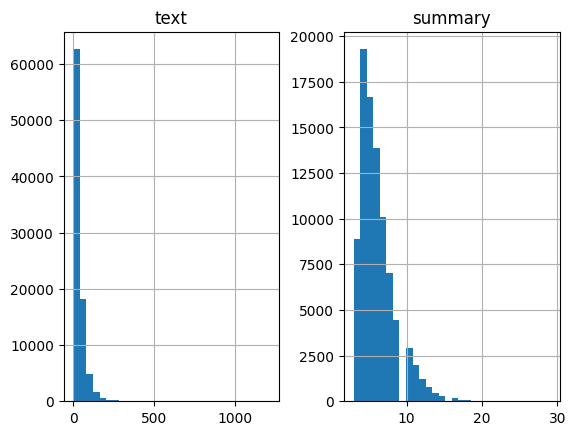

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
# We can fix the maximum length of the reviews to 80 since that seems to be the majority review length. Similarly, we can set the maximum summary length to 10
max_len_text = 80
max_len_summary = 10

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'], data['cleaned_summary'], test_size=0.1, random_state=0, shuffle=True)


In [ ]:
# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr = pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1


In [ ]:
# preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# convert summary sequences into integer sequences
y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1


In [ ]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
# Word embeddings provide a dense representation of words and their relative meanings, each input integer is used as the index to access a table that contains all possible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
# Attention layer attn_layer = AttentionLayer(name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
# decoder_concat_input = Concatenate(
#     axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 500)   │ 25,886,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 80, 500), │  2,002,000 │ embedding[0][0]   │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 80, 500), │  2,002,000 │ lstm[0][0]        │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 500) │  7,073,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 80, 500), │  2,002,000 │ lstm_1[0][0]      │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  2,002,000 │ embedding_1[0][0… │
│                     │ 500), (None,      │            │ lstm_2[0][1],     │
│                     │ 500), (None,      │            │ lstm_2[0][2]      │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  7,087,146 │ lstm_3[0][0]      │
│ (TimeDistributed)   │ 14146)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,054,646 (183.31 MB)

 Trainable params: 48,054,646 (183.31 MB)

 Non-trainable params: 0 (0.00 B)

Using sparse `categorical cross-entropy` as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Remember the concept of early stopping? It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], epochs=20,
                    batch_size=512, validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))


Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 647ms/step - loss: 4.5843 - val_loss: 2.9868
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 109s 699ms/step - loss: 3.0754 - val_loss: 2.9540
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 111s 715ms/step - loss: 3.0510 - val_loss: 2.9354
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 718ms/step - loss: 3.0140 - val_loss: 2.8748
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 715ms/step - loss: 2.9599 - val_loss: 2.8365
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 717ms/step - loss: 2.9151 - val_loss: 2.8204
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 718ms/step - loss: 2.8784 - val_loss: 2.7643
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 715ms/step - loss: 2.8657 - val_loss: 2.7448
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 715ms/step - loss: 2.8341 - val_loss: 2.7287
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 716ms/step - loss: 2.7958 - val_loss: 2.6941
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 717ms/step - loss: 2.7625 - val_loss: 2.6805
Epoch 12

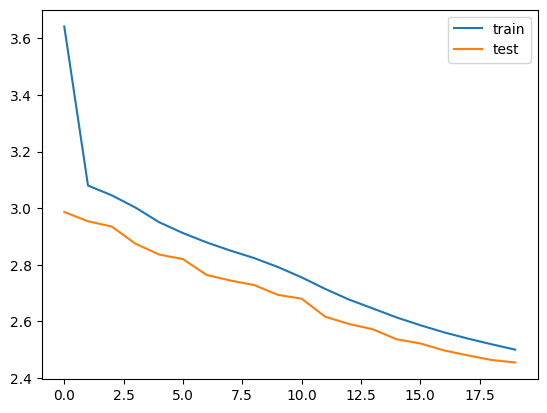

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2, state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered in the above section)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        # In the previous decoder_model definition, e_out was an input. Now it's not.
        # The decoder model expects only target_seq, e_h, e_c.
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews

In [ ]:
def seq2summary(input_seq):
    '''
    convert an integer sequence to a word sequence for summary
    '''
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    '''
    convert an integer sequence to a word sequence for reviews
    '''
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(20, 30):
  print("Review:", seq2text(x_val[i]))
  print("Original summary:", seq2summary(y_val[i]))
  print("Predicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
  print("\n")

Review: might work well training way tiny treat give whole handful disappointed 
Original summary: too tiny 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted summary:  great for training


Review: gluten free want crackers one also delicious second order 
Original summary: cracker of cracker 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted summary:  great for my dog


Review: love using fresh ginger lemon cook saw ginger lemon drink try flavor good leave slight taste enough deter trying complaint received sample pack gold kili drink directions much water use tend like foods drinks flavorful opted regular coffee mug found strong ended pouring largest 